Импорт библиотек

In [78]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, plot_precision_recall_curve

from scipy.stats import chi2_contingency, shapiro, probplot, mannwhitneyu

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

Функции. Попытался отбалансировать целевую переменную, но не вышло:(

def balance_df_by_target(train, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = train[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = train[train[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            train = train.append(sample, ignore_index=True)
            
    elif method == 'under':
        train = train.copy()
        train = train_[train_[target_name] == minor_class_name]
        tmp = train_[train_[target_name] == major_class_name]
        train = train.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(train.drop(columns=target_name), train[target_name])
        train = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(train.drop(columns=target_name), train[target_name])
        train = pd.concat([X_smote, y_smote], axis=1)

    return train.sample(frac=1)

In [80]:
target_counts = train[target_name].value_counts()
target_counts

0    5387
1    2113
Name: Credit Default, dtype: int64

Пути и загрузка

In [82]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [83]:
target_name = 'Credit Default'
feature_names = train.columns.drop(target_name).tolist()
feature_names_num = train.select_dtypes(include='float64').columns.tolist()
feature_names_cat = train.select_dtypes(include=['int64', 'object']).columns.drop(target_name).tolist()

Чекаем данные

In [84]:
train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [85]:
test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target_name, method='smote')
    
df_balanced[target_name].value_counts()

Проверяем на пропуски

In [86]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [87]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

Работаем с пропусками

In [88]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.0,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.5,209323.0,360406.25,6.506797e+06


In [89]:
Current_Loan_Amount_max = 700000
Maximum_Open_Credit_max = train['Maximum Open Credit'].quantile(.95)
medians = train[['Annual Income', 'Credit Score']].median()
train['Years in current job'].fillna('nan', inplace=True)
train['Months since last delinquent'].fillna(0, inplace=True)
train['Bankruptcies'].fillna(0, inplace=True)
train['Annual Income'].fillna(medians['Annual Income'], inplace=True)
train['Credit Score'].fillna(medians['Credit Score'], inplace=True)

Работаем с выбросами

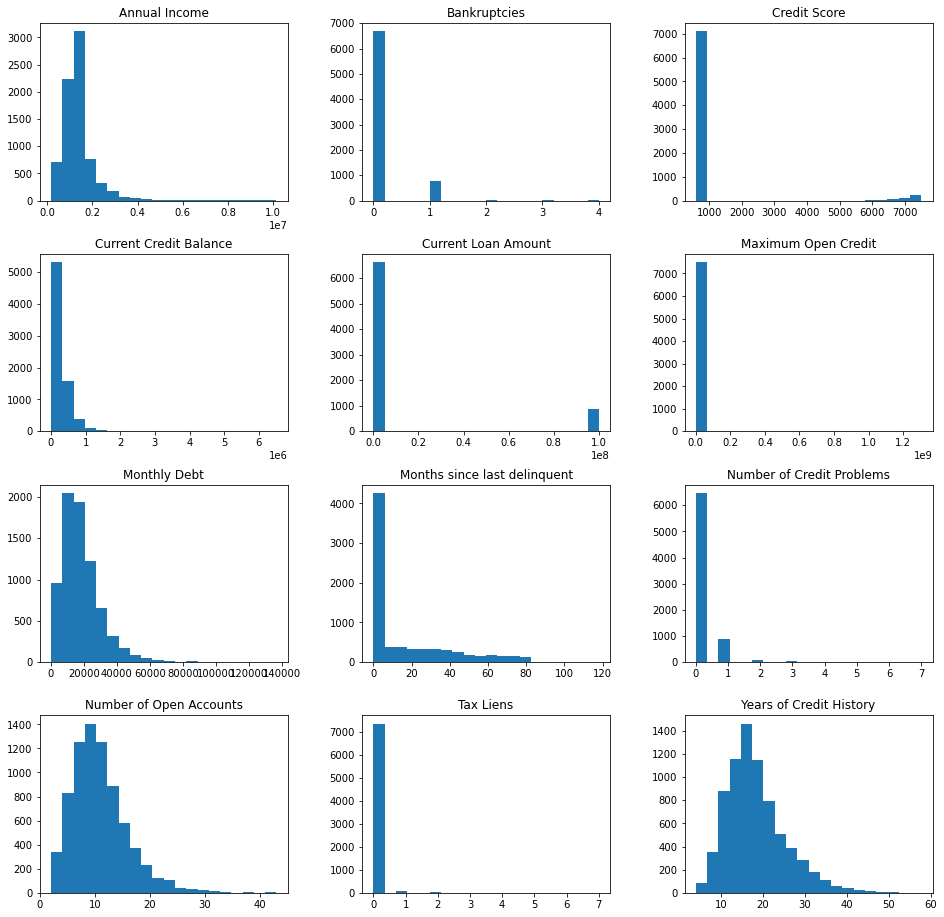

In [90]:
train[feature_names].hist(figsize=(16,16), bins=20, grid=False);

In [91]:
train.loc[train['Current Loan Amount'] > Current_Loan_Amount_max, 'Current Loan Amount'] = Current_Loan_Amount_max
train.loc[train['Maximum Open Credit'] > Maximum_Open_Credit_max, 'Maximum Open Credit'] = Maximum_Open_Credit_max
train[['Tax Liens', 'Bankruptcies', 'Number of Credit Problems']] = train[['Tax Liens', 'Bankruptcies', 'Number of Credit Problems']].astype(int)

Коррелируем фичи с целевой переменной

Text(0.5, 1.0, 'Correlation with target variable')

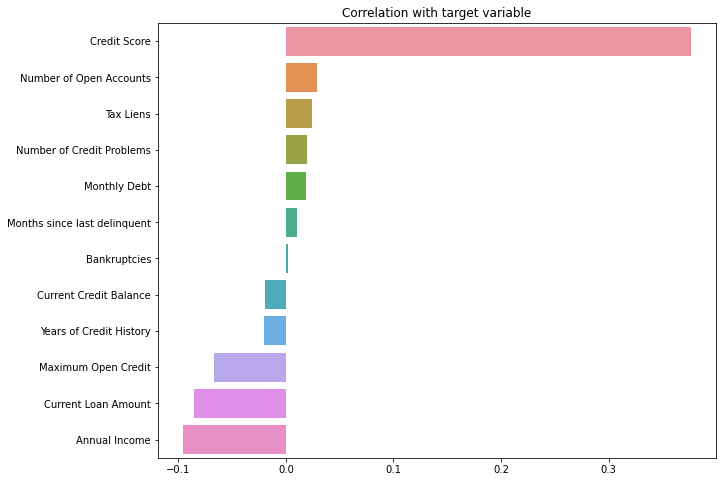

In [92]:
corr_with_target = train[feature_names + [target_name]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')

Коррелируем Credit Score с целевой переменной в разрезе классов

Text(0.5, 1.0, 'Credit Score grouped by target variable')

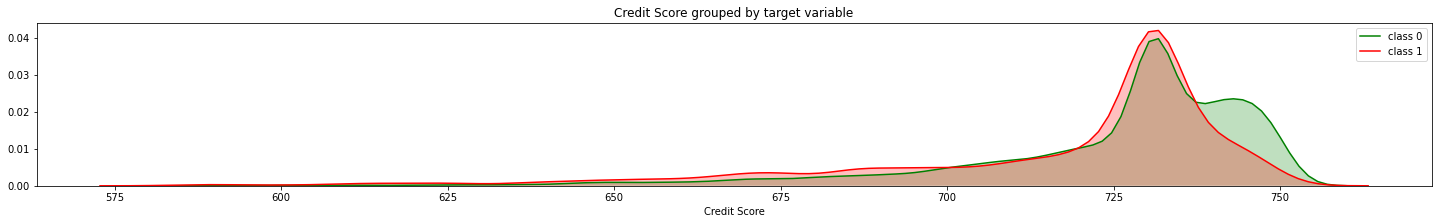

In [93]:
credit_score_with_target = train[train['Credit Score'] < 1000][['Credit Score', target_name]]
credit_score = credit_score_with_target['Credit Score']
credit_score_target_0 = credit_score[credit_score_with_target[target_name] == 0]
credit_score_target_1 = credit_score[credit_score_with_target[target_name] == 1]

plt.figure(figsize=(25, 3))

sns.kdeplot(credit_score_target_0, shade=True, label='class 0', color='g')
sns.kdeplot(credit_score_target_1, shade=True, label='class 1', color='r')

plt.xlabel('Credit Score')
plt.title('Credit Score grouped by target variable')

Объеденяем значения

In [94]:
train.loc[train['Number of Credit Problems'] == 4,'Number of Credit Problems'] = 1
train.loc[train['Tax Liens'] == 2,'Tax Liens'] = 1

Пробуем

In [95]:
X = train[feature_names]
y = train[target_name]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=True,
    test_size=0.1,
    random_state=42,
    stratify=y
)

In [96]:
params = {
    'eval_metric': 'F1',
    'auto_class_weights': 'Balanced',
    'silent': True,
    'cat_features': feature_names_cat,
    'one_hot_max_size': 20,
    'early_stopping_rounds': 50,
    'boosting_type': 'Ordered',
    'allow_writing_files': False
}

In [97]:
%%time

cbr_final_model = CatBoostClassifier(
    **params,
    depth=6,
    iterations=100,
    learning_rate=0.5
)

cbr_final_model.fit(X_train, y_train, eval_set=(X_test, y_test))

Wall time: 1.66 s


In [98]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    cv_score = cross_val_score(
        model,
        X_train,
        y_train,
        scoring='f1',
        cv=StratifiedKFold(
            n_splits=5,
            random_state=42,
            shuffle=True
        )
    )
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred, cv_score)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred, pos_label=1)
    plt.rcParams['figure.figsize'] = 5, 5
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], color='grey', linestyle='dashed')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    
    disp = plot_precision_recall_curve(model, X_test, y_test)
    disp.ax_.set_title('Precision-Recall curve')

In [99]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred, cv_score):
    
    print('Train\n\n' + classification_report(y_train_true, y_train_pred))
    print('Test\n\n' + classification_report(y_test_true, y_test_pred))
    print('Confusion Matrix\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    print('\nCross Validation Score: ' + str(round(cv_score.mean(),3)))

Train

              precision    recall  f1-score   support

           0       0.85      0.75      0.80      4848
           1       0.51      0.66      0.58      1902

    accuracy                           0.73      6750
   macro avg       0.68      0.71      0.69      6750
weighted avg       0.76      0.73      0.74      6750

Test

              precision    recall  f1-score   support

           0       0.84      0.73      0.78       539
           1       0.48      0.63      0.55       211

    accuracy                           0.71       750
   macro avg       0.66      0.68      0.66       750
weighted avg       0.74      0.71      0.72       750

Confusion Matrix

col_0             0    1
Credit Default          
0               396  143
1                78  133

Cross Validation Score: 0.522


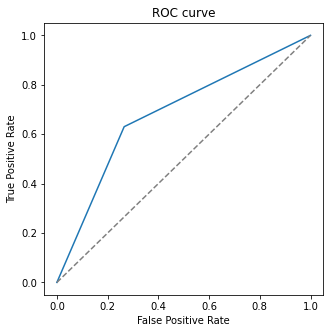

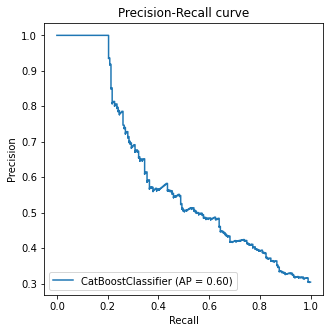

In [100]:
evaluate_preds(cbr_final_model, X_train, X_test, y_train, y_test)

Смотрим фичи

In [101]:
feature_importances = pd.DataFrame(
    zip(X.columns, cbr_final_model.get_feature_importance()),
    columns=['feature_name', 'importance']
)

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
15,Credit Score,42.553338
12,Current Loan Amount,16.634955
11,Term,13.120648
1,Annual Income,11.159482
14,Monthly Debt,4.382908
6,Maximum Open Credit,3.582089
13,Current Credit Balance,2.185793
2,Years in current job,2.008285
0,Home Ownership,1.604091
4,Number of Open Accounts,1.002586


Проверка на тесте

In [102]:
Current_Loan_Amount_max = 700000
Maximum_Open_Credit_max = test['Maximum Open Credit'].quantile(.95)
medians = test[['Annual Income', 'Credit Score']].median()
test['Years in current job'].fillna('nan', inplace=True)
test['Months since last delinquent'].fillna(0, inplace=True)
test['Bankruptcies'].fillna(0, inplace=True)
test['Annual Income'].fillna(medians['Annual Income'], inplace=True)
test['Credit Score'].fillna(medians['Credit Score'], inplace=True)
test.loc[test['Current Loan Amount'] > Current_Loan_Amount_max, 'Current Loan Amount'] = Current_Loan_Amount_max
test.loc[test['Maximum Open Credit'] > Maximum_Open_Credit_max, 'Maximum Open Credit'] = Maximum_Open_Credit_max
        
test[['Tax Liens', 'Bankruptcies', 'Number of Credit Problems']] = test[['Tax Liens', 'Bankruptcies', 'Number of Credit Problems']].astype(int)
test.loc[test['Number of Credit Problems'] == 4,'Number of Credit Problems'] = 1
test.loc[test['Tax Liens'] == 2,'Tax Liens'] = 1

In [103]:
y_test_pred = cbr_final_model.predict(test)

preds_final = pd.DataFrame()
preds_final = pd.DataFrame({'Id': np.arange(0,y_test_pred.shape[0]), 'Credit Default': y_test_pred})
preds_final.to_csv('./GARIFULLIN.csv', index=False, encoding='utf-8', sep=',')
preds_final.head(10)

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,0
4,4,0
5,5,0
6,6,1
7,7,1
8,8,0
9,9,0
